# ABOUT:
- this notebook:
    - performs **random search** to find the best parameters for catboost
        - the approach was to use two rounds of random search
        - first round with a larger paramter space and second round with a small parameter space
    - fits best params found
- insights:
    - the above **two-round random search approach does not work well**, first round usually yield the best parameters already
    - Optuna (from subsequent notebooks) is a better approach to tuning

### import data

In [8]:
import pandas as pd
train = pd.read_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\cleaned_train_set.csv",index_col = "respondent_id") 

In [2]:
from datasets import ClassLabel, Sequence
import pandas as pd
from IPython.display import display, HTML
def show_elements(dataset, randomize = True, num_samples = 10):
    
    if isinstance(dataset,pd.DataFrame):                  # if DataFrame 
        if randomize:                                          # if random> shuffle
            dataset = dataset.sample(frac=1)
        display(HTML(dataset.iloc[:num_samples].to_html()))             # take first n rows
    
    else:                                                    # if not DataFrame
        if randomize:                                           # if random> shuffle
            dataset = dataset.shuffle()   
        dataset = pd.DataFrame(dataset.select(range(num_samples)))   # convert first n rows to dataframe
        display(HTML(dataset.to_html()))
    

In [3]:
show_elements(train)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26251,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0,4.0,4.0,1.0,0.0,0.0,0,1,3,2,0,1,1,0,0,0,9,2,0,0
17455,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,4.0,4.0,2.0,1.0,1.0,0.0,1,0,3,2,0,1,1,1,0,1,5,0,8,22
7510,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,5.0,4.0,2.0,5.0,1.0,2.0,0,0,1,3,0,1,2,1,0,1,2,1,5,2
8096,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,1.0,2.0,5.0,4.0,2.0,0.0,0.0,0,1,3,3,0,1,1,0,0,0,0,1,0,0
878,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,4.0,1.0,2.0,4.0,2.0,2.0,0.0,0.0,0,1,0,2,0,1,1,0,0,1,6,1,4,4
2942,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,1.0,2.0,4.0,1.0,2.0,1.0,0.0,0,0,0,2,0,1,2,1,0,1,2,1,1,1
20623,3.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,1.0,5.0,5.0,1.0,2.0,1.0,0.0,0,1,1,2,0,0,1,1,0,1,9,1,0,0
11902,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,4.0,2.0,2.0,4.0,2.0,2.0,1.0,0.0,0,0,4,3,0,0,1,0,0,0,1,0,0,0
4777,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,0,0,2,1,0,0,2,0,0,1,2,2,2,19


### Declare train features and labels

In [9]:
target_colnames = ['h1n1_vaccine', 'seasonal_vaccine']
features = [col for col in train.columns if col not in target_colnames]

In [10]:
X = train[features]
y = train[target_colnames[1]]

In [11]:
y.name

'seasonal_vaccine'

## Cross Validate catboost
- this custom function performs cross validation on catboost and returns the best performing iteration

In [6]:
from catboost import CatBoostClassifier, Pool, cv
def catboost_cv(X, y, params, nfolds=5, cat_features = []):
                
    cv_dataset = Pool(data=X,                                       # cv requires a Pool dataset
                      label=y,
                      cat_features = cat_features)
    
    scores = cv(cv_dataset,                                          # perform cv
                params,
                fold_count=nfolds, 
                plot="True",
                verbose=False,
                seed = 0)                                       # return best iteration
    test_metric_colname = [col for col in scores.columns if "test" in col and "mean" in col][0]
    print("Best Iteration:")
    if "loss" in test_metric_colname:
        for k,v in scores.iloc[scores[test_metric_colname].idxmin()].items():
            print(f"{k}:{v}")
    else:
        for k,v in scores.iloc[scores[test_metric_colname].idxmax()].items():
            print(f"{k}:{v}")

In [8]:
params = {"learning_rate":0.1,
          "depth":5,
          "l2_leaf_reg" : 9,
          "iterations" : 500,
          "loss_function": "Logloss",
          "eval_metric":"AUC"}
catboost_cv(X,y,params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best Iteration

iterations:0.0
test-AUC-mean:0.7997403328128403
test-AUC-std:0.00705144362057019
test-Logloss-mean:0.6606248485838442
test-Logloss-std:0.0006734689261697163
train-Logloss-mean:0.6604015564736629
train-Logloss-std:0.0004046583028334367


# Hyperparameter tuning

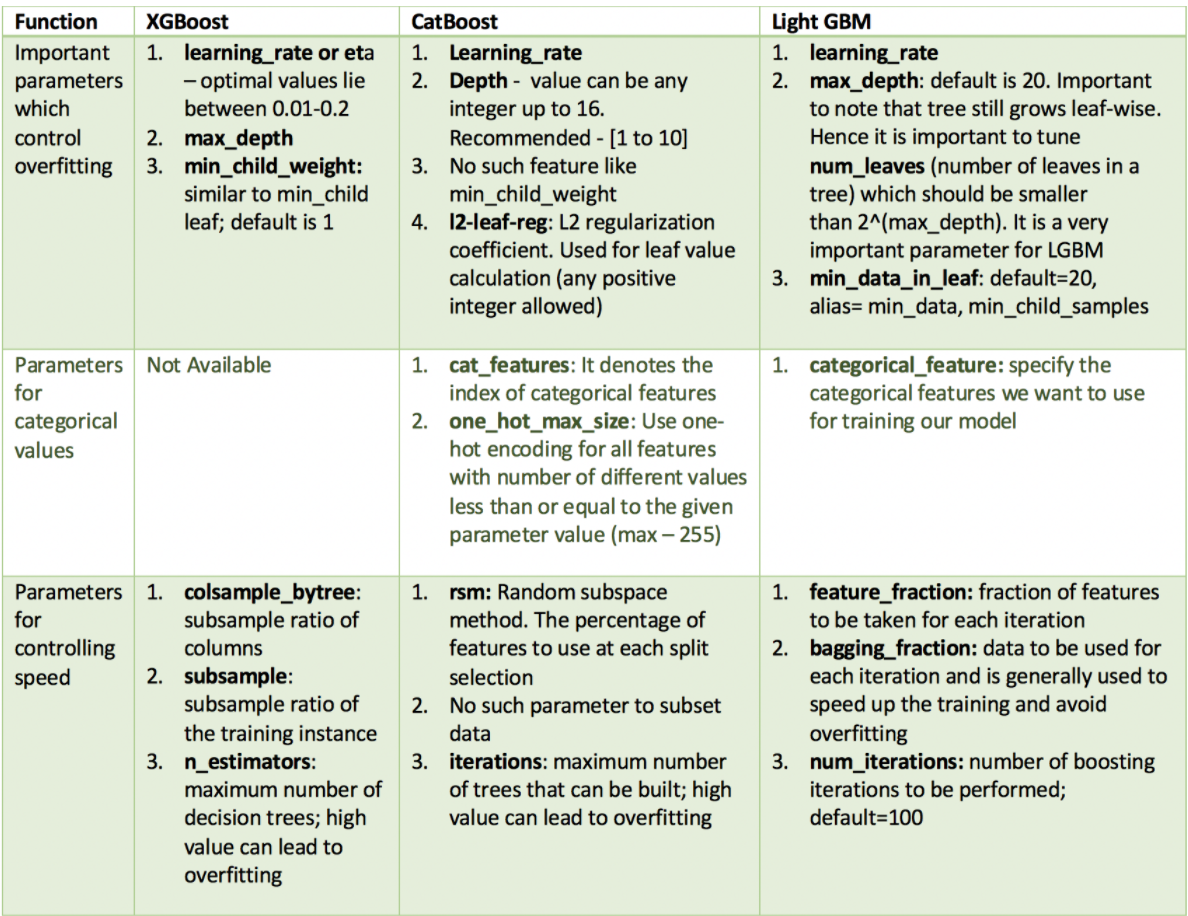

In [9]:
from IPython.display import Image
Image(filename=r"C:\Users\tanch\Documents\DataScienceLearning\xgboost catboost lightgbm parameters.PNG") 

## Random Search - round 1
- we use a **large range for the parameter grid** and fixed high learning rate and low iterations
- this custom function performs random search and returns the best params

In [10]:
param_distributions = {
              "depth":range(2,11,2),
              "l2_leaf_reg" : np.random.uniform(2,10,2000),
              "auto_class_weights":[None,"Balanced","SqrtBalanced"],
              "rsm":np.random.uniform(0,1,2000)
          }

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
def random_search_catboost(param_distributions, 
                           n_iter,
                           fixed_params = {"learning_rate" : 0.1,
                                            "iterations" :  300,
                                            "loss_function" : "Logloss",
                                            "verbose":False,
                                            "task_type" : "CPU",
                                            "eval_metric":"AUC"}):
    model = CatBoostClassifier()
    model.set_params(**fixed_params)
    randomized_search_result = model.randomized_search(param_distributions = param_distributions,
                                                       n_iter = n_iter,
                                                       train_size = 0.7,
                                                       X=X,
                                                       y=y,
                                                       plot=False,
                                                       partition_random_seed = 0,
                                                       search_by_train_test_split = True,    # no cv is used to search 
                                                       calc_cv_statistics = True,  # Estimate the quality by using cross-validation with the best of the found parameters
                                                       refit = False,
                                                       shuffle = True, 
                                                       stratified = True,
                                                       verbose = 1
                                                       )
    return randomized_search_result

In [12]:
randomized_search_result = random_search_catboost(param_distributions,100)


bestTest = 0.8582758878
bestIteration = 298

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8582759	best: 0.8582759 (0)	total: 3.11s	remaining: 5m 7s

bestTest = 0.8609917722
bestIteration = 295

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8609918	best: 0.8609918 (1)	total: 7.25s	remaining: 5m 55s

bestTest = 0.8581465256
bestIteration = 299

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8581465	best: 0.8609918 (1)	total: 10.7s	remaining: 5m 47s

bestTest = 0.8576525377
bestIteration = 93

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8576525	best: 0.8609918 (1)	total: 28.8s	remaining: 11m 31s




bestTest = 0.8594896053
bestIteration = 168

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
33:	loss: 0.8594896	best: 0.8618045 (8)	total: 4m 41s	remaining: 9m 5s

bestTest = 0.8453820537
bestIteration = 299

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
34:	loss: 0.8453821	best: 0.8618045 (8)	total: 4m 44s	remaining: 8m 47s

bestTest = 0.8593536028
bestIteration = 109

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
35:	loss: 0.8593536	best: 0.8618045 (8)	total: 4m 54s	remaining: 8m 43s

bestTest = 0.8613688957
bestIteration = 277

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
36:	loss: 0.8613689	best: 0.8618045 (8)	total: 4m 58s	remaining: 


bestTest = 0.8619023814
bestIteration = 250

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
66:	loss: 0.8619024	best: 0.8619024 (66)	total: 9m 35s	remaining: 4m 43s

bestTest = 0.8604985673
bestIteration = 299

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
67:	loss: 0.8604986	best: 0.8619024 (66)	total: 9m 39s	remaining: 4m 32s

bestTest = 0.8615819517
bestIteration = 299

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
68:	loss: 0.8615820	best: 0.8619024 (66)	total: 9m 44s	remaining: 4m 22s
Estimating final quality...


In [3]:
# PLots the Best catboost model
# displays the best paramss
# displays the best metric score
import seaborn as sns
def plot_randomized_search_result(randomized_search_result):
    best_params, cv_results = randomized_search_result["params"],randomized_search_result["cv_results"]
    metric = list(randomized_search_result['cv_results'].keys())[1]
    best_score = min(cv_results[metric]) if "loss" in metric else max(cv_results[metric])
    print(f"best_params: {best_params}\nBest {metric}: {best_score}")
    sns.lineplot(data = cv_results, x = "iterations", y = metric)

best_params: {'depth': 4, 'rsm': 0.93789016484649, 'l2_leaf_reg': 7.847914167208884, 'auto_class_weights': 'SqrtBalanced'}
Best test-AUC-mean: 0.862619839492922


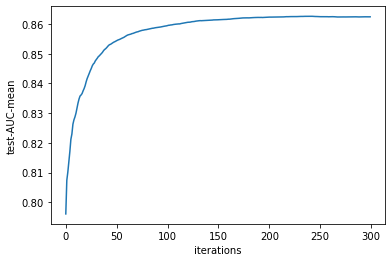

In [14]:
plot_randomized_search_result(randomized_search_result)

## Random Search - round 2
- with **reduced range for the parameter grid** centered at the best params found in round 1 and fixed learning rate and iterations

In [1]:
param_distributions = {
    "depth":[3,4,5],
    "l2_leaf_reg" : np.random.uniform(7.84-0.2,7.84+0.2,2000),
    "rsm":np.random.uniform(0.937-0.05,0.937+0.05,2000)
}
fixed_params = {
    "learning_rate" : 0.1,
    "iterations" :  300,
    "loss_function" : "Logloss",
    "verbose":False,
    "auto_class_weights":"SqrtBalanced",
    "task_type" : "CPU",
    "eval_metric":"AUC"
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
randomized_search_result = random_search_catboost(param_distributions,30,fixed_params)


bestTest = 0.8612930951
bestIteration = 206

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8612931	best: 0.8612931 (0)	total: 10s	remaining: 4m 50s

bestTest = 0.8605356532
bestIteration = 296

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8605357	best: 0.8612931 (0)	total: 15s	remaining: 3m 29s

bestTest = 0.8601080377
bestIteration = 299

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8601080	best: 0.8612931 (0)	total: 20.5s	remaining: 3m 4s

bestTest = 0.8613010511
bestIteration = 193

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8613011	best: 0.8613011 (3)	total: 27.7s	remaining: 2m 59s

best

best_params: {'depth': 4, 'rsm': 0.9644763012504156, 'l2_leaf_reg': 7.996980404732743}
Best test-AUC-mean: 0.8625832368758467


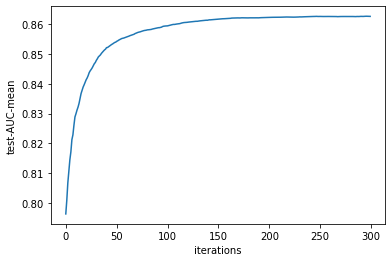

In [13]:
plot_randomized_search_result(randomized_search_result)    # no improvement

## Fit best params
- with **lower learning rate and higher iteration at best params**
- applies early stopping
- fit_best_model() 
    - returns the best model using early stopping

In [14]:
params = {
    "learning_rate" : 0.01,
    "iterations" :  3000,
    'depth': 4, 
    'rsm': 0.93789016484649, 
    'l2_leaf_reg': 7.847914167208884, 
    'auto_class_weights': 'SqrtBalanced',
    "loss_function" : "Logloss",
    "verbose":False,
    "task_type" : "CPU",
    "eval_metric":"AUC"
}

In [15]:
from sklearn.model_selection import train_test_split
def fit_best_model(params, X, y , early_stopping_rounds,test_size = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size, random_state = 0, shuffle = True, stratify = y)
    model = CatBoostClassifier()
    model.set_params(**params)
    model.fit(X_train, y_train , 
              eval_set = (X_test, y_test),
              early_stopping_rounds=early_stopping_rounds,
              plot=True,
              use_best_model = True)
    return model

In [16]:
best_model = fit_best_model(params, X, y , early_stopping_rounds = 50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### further fine tuning
- further fine tune on the **remaining unseen samples from training set** (eval set) at a very low learning rate and iteration
- this can be done using the "init_model" parameter 

In [17]:
params = {
    "learning_rate" : 0.001,
    "iterations" :  200,
    'depth': 4, 
    'rsm': 0.93789016484649, 
    'l2_leaf_reg': 7.847914167208884, 
    'auto_class_weights': 'SqrtBalanced',
    "loss_function" : "Logloss",
    "verbose":False,
    "task_type" : "CPU",
    "eval_metric":"AUC"
}

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = True, stratify = y)
best_model_plus = CatBoostClassifier()
best_model_plus.set_params(**params)
best_model_plus.fit(X_test, y_test, init_model=best_model)


## save_model

In [19]:
best_model.save_model(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\model\seasonal_vaccine catboost")
best_model_plus.save_model(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\model\seasonal_vaccine catboost plus")